# Clase 5: Deep Learning CNN, Autoencoders y Embeddings
---

<img src="../img/sergio_portrait_square.png" alt="Sergio Benito" align="right" width="100">

- **Autor:** Sergio Benito Martín
- **Contacto:** pontia@sergiobenito.com
- **Última actualización:** 03/07/2025

### Objetivo
Conocer algunos otros tipos de redes neuronales que son más apropiadas para otros tipos de datos como imágenes o textos, como son las Redes Neuronales Convolucionales (CNN), Embeddings y Autoencoders.

También, dada la naturaleza de este paradigma, empezaremos a trabajar con datos no estructurados como son las imágenes.

<center><img src="https://www.louisbouchard.ai/content/images/size/w2000/2021/04/1_QPRC1lcfYxcWWPAC2hrQgg.gif" alt="Ejemplo CNN" width=700/></center>
<center><a src="https://www.louisbouchard.ai/densenet-explained/">Fuente: Louis-François Bouch - State-of-the-Art Convolutional Neural Networks Explained - DenseNet</a></center>

### Temas a tratar

1. Redes Neuronales Convolucionales (CNN)
2. Introducción Autoencoders
3. Embeddings
4. Ejercicios para practicar

### Información útil
+ Medium:
  + [Autoencoders](https://medium.com/@piyushkashyap045/a-comprehensive-guide-to-autoencoders-8b18b58c2ea6)
  + [Convolutional Neural Networks for Dummies](https://medium.com/@prathammodi001/convolutional-neural-networks-for-dummies-a-step-by-step-cnn-tutorial-e68f464d608f)
  + [Understanding Convolutional Neural Networks 🧠: A Beginner’s Journey into the Architecture 🚀](https://medium.com/codex/understanding-convolutional-neural-networks-a-beginners-journey-into-the-architecture-aab30dface10)
+ Documentación oficial:
---


### Para profundizar más 🤓

## 0. Configuración del Notebook
Importaremos todas las librerías y funciones que vemos relevantes para el notebook que vamos a crear. Lo ideal sería tener todas las importaciones juntas, de tal manera que se puedan controlar de manera sencilla.

In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 11.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

### Importación de librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import re
import tensorflow as tf

from gensim.models import Word2Vec
from sklearn.datasets import load_iris
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras import layers, models

In [2]:
# Importamos esta librería para solventar el problema que podáis tener para visualizar gráficos con Plotly
from IPython.display import HTML

### Definición de constantes

In [4]:
# Paths
PATH_DIRECTORIO_DATOS = "./data"

PATH_DATASET_ADVERTISING = f"{PATH_DIRECTORIO_DATOS}/advertising.csv"
PATH_DATASET_CALORIES = f"{PATH_DIRECTORIO_DATOS}/calories.csv"
PATH_DATASET_CALORIES_LITE = f"{PATH_DIRECTORIO_DATOS}/calories_time_reduc.csv"
PATH_DATASET_CALORIES_TIME = f"{PATH_DIRECTORIO_DATOS}/calories_time.csv"
PATH_DATASET_HEART = f"{PATH_DIRECTORIO_DATOS}/heart_disease.csv"
PATH_DATASET_BOSTON = f"{PATH_DIRECTORIO_DATOS}/housing_boston.csv"
PATH_DATASET_TWEETS = f"{PATH_DIRECTORIO_DATOS}/nlp_tweets.csv"

# Datasets de Internet
URL_DATASET_PENGUINS = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"

In [5]:
IF_PLOTLY_FAILS = False

### Definición de funciones

In [6]:
# Obtenemos el embedding de cada frase (media de los embeddings de sus palabras)
def get_sentence_embedding(w2v, sentence):
    """    Obtiene el embedding de una frase como la media de los embeddings de sus palabras.
    Args:
        w2v (Word2Vec): Modelo Word2Vec entrenado.
        sentence (str): Frase a procesar.
    Returns:
        np.ndarray: Embedding de la frase.
    """

    # Convertimos la frase a minúsculas, la separamos en palabras y obtenemos los vectores de las palabras
    words = sentence.lower().split()

    # Usamos el modelo Word2Vec para obtener los vectores de las palabras
    # Si una palabra no está en el vocabulario, la ignoramos
    vectors = [w2v.wv[w] for w in words if w in w2v.wv]

    # Finalmente, calculamos la media de los vectores de las palabras
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v.vector_size)

In [7]:
def limpiar_texto(text):
    """
    Limpia el texto eliminando URLs, caracteres especiales, menciones (@) y convirtiendo a minúsculas.

    Args:
        text (str): Texto a limpiar.
    Returns:
        str: Texto limpio.
    """
    # Convertir a cadena y a minúsculas
    text = str(text).lower()

    # Eliminar URLs
    text = re.sub(r'http\S+', '', text)

    # Eliminar menciones (@usuario)
    text = re.sub(r'@\w+', '', text)

    # Eliminar caracteres especiales
    text = re.sub(r'[^a-záéíóúñü\s]', '', text)

    # Eliminar espacios extra
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### Carga de datos

#### Digits MNIST

In [8]:
# Cargar el dataset MNIST directamente desde Keras
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Visualizamos las dimensiones de los datos
print(f"Dimensiones de X_train: {X_train_mnist.shape}, Dimensiones de y_train: {y_train_mnist.shape}")
print(f"Dimensiones de X_test: {X_test_mnist.shape}, Dimensiones de y_test: {y_test_mnist.shape}")

Dimensiones de X_train: (60000, 28, 28), Dimensiones de y_train: (60000,)
Dimensiones de X_test: (10000, 28, 28), Dimensiones de y_test: (10000,)


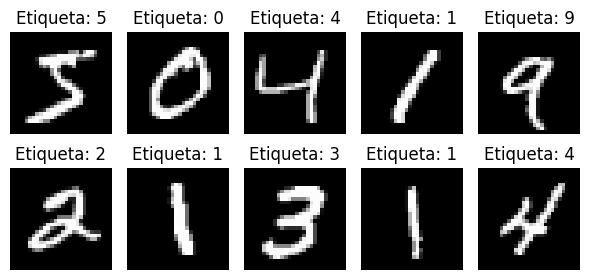

In [10]:
# Visualizamos algunas imágenes del dataset MNIST
fig, axes = plt.subplots(2, 5, figsize=(6, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_mnist[i], cmap='gray')
    ax.set_title(f"Etiqueta: {y_train_mnist[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Normalizamos los datos dividiendo por 255 para que estén en el rango [0, 1]


In [12]:
# Añadir una dimensión para los canales (grayscale)
# Se utiliza para CNN ya que de esta manera añadimos una dimensión extra que representa los canales de color (en este caso, 1 canal para imágenes en escala de grises)
# En este caso, las imágenes son en escala de grises, por lo que se añade una dimensión al final del array


print(f"Nuevo shape: {X_train_mnist_preprocessed.shape}")

Nuevo shape: (60000, 28, 28, 1)


#### Fashion MNIST
Es otro dataset típico de imágenes que se puede importar directamente de Keras, contiene diferente imágenes de diferentes tipos de predas de ropa y zapatillas. Para importar la función que se utiliza para descargarlo se puede usar:
```python
from tensorflow.keras.datasets import fashion_mnist
```

In [13]:
# Cargar Fashion MNIST
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = fashion_mnist.load_data()

# Visualizamos las dimensiones de los datos
print(f"Dimensiones de X_train: {X_train_fashion.shape}, Dimensiones de y_train: {y_train_fashion.shape}")
print(f"Dimensiones de X_test: {X_test_fashion.shape}, Dimensiones de y_test: {y_test_fashion.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dimensiones de X_train: (60000, 28, 28), Dimensiones de y_train: (60000,)
Dimensiones de X_test: (10000, 28, 28), Dimensiones de y_test: (10000,)


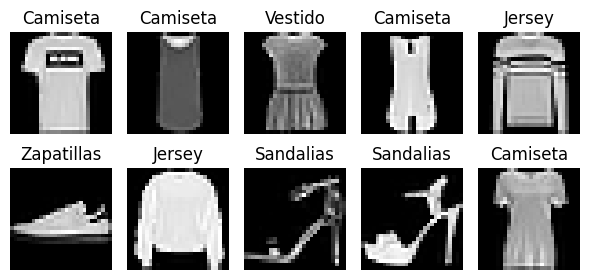

In [58]:
# Visualizar algunas imágenes con sus etiquetas
list_class_names_fashion = [
    'Camiseta', 'Pantalón', 'Jersey', 'Vestido', 'Abrigo',
    'Sandalias', 'Camisa', 'Zapatillas', 'Bolso', 'Bota'
]

# Visualizamos algunas imágenes del dataset MNIST
fig, axes = plt.subplots(2, 5, figsize=(6, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_fashion[i+1], cmap='gray')
    ax.set_title(f"{list_class_names_fashion[y_train_fashion[i+1]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [59]:
# Normalizamos los datos dividiendo por 255 para que estén en el rango [0, 1]
X_train_fashion_preprocessed = X_train_fashion.astype('float32') / 255.0
X_test_fashion_preprocessed = X_test_fashion.astype('float32') / 255.0

In [60]:
# Añadir una dimensión para los canales (grayscale)
# Se utiliza para CNN ya que de esta manera añadimos una dimensión extra que representa los canales de color (en este caso, 1 canal para imágenes en escala de grises)
# En este caso, las imágenes son en escala de grises, por lo que se añade una dimensión al final del array
X_train_fashion_preprocessed = np.expand_dims(X_train_fashion_preprocessed, -1)
X_test_fashion_preprocessed = np.expand_dims(X_test_fashion_preprocessed, -1)

print(f"Nuevo shape: {X_train_fashion_preprocessed.shape}")

Nuevo shape: (60000, 28, 28, 1)


#### Tweets

In [17]:
# Cargar el dataset de tweets
df_tweets = pd.read_csv(PATH_DATASET_TWEETS)
df_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [18]:
# Eliminamos filas vacías


In [19]:
# Aplicamos la función que limpia el texto


In [20]:
# Convertimos a una lista los textos de la columna del tweet procesado

print(tweets_corpus)

['what said', 'plus youve added commercials to the experience tacky', 'i didnt today must mean i need to take another trip', 'its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse', 'and its a really big bad thing about it', 'seriously would pay a flight for seats that didnt have this playing its really the only bad thing about flying va', 'yes nearly every time i fly vx this ear worm wont go away', 'really missed a prime opportunity for men without hats parody there', 'well i didntbut now i do d', 'it was amazing and arrived an hour early youre too good to me', 'did you know that suicide is the second leading cause of death among teens', 'i lt pretty graphics so much better than minimal iconography d', 'this is such a great deal already thinking about my nd trip to amp i havent even gone on my st trip yet p', 'im flying your fabulous seductive skies again u take all the stress away from travel', 'thanks', 'sfopdx schedule is still mi

## 1. Redes Neuronales Convolucionales (CNN)
Vamos a implementar una Red Neuronal Convolucional (CNN) ya que son redes especializadas para procesar datos con estructura espacial, como imágenes (y también audio, video…), cuya ventaja es detectar patrones (bordes y formas) aprovechando la disposición de los datos dentro de una matriz de entrada.

<center><img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*HxYdjdOD9xdjDPzGM313Fg.jpeg" alt="Ejemplo CNN" width=500/></center>

Si desglosamos el esquema anterior en un ejemplo concreto sería algo tal que así:
<center><img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*eiWpSVh65QZN9usE6YRJTA.png" alt="Ejemplo CNN" width=800/></center>
<center><a src="https://medium.com/codex/understanding-convolutional-neural-networks-a-beginners-journey-into-the-architecture-aab30dface10">Fuente: Medium - Understanding Convolutional Neural Networks 🧠: A Beginner’s Journey into the Architecture 🚀</a></center>

| Capa                | ¿Qué hace?                                                                        | Llamada en Keras                                          | Hiperparámetros clave y explicación                                           |
|---------------------|-----------------------------------------------------------------------------------|-----------------------------------------------------------|-------------------------------------------------------------------------------|
| **Input**           | Define la forma de los datos de entrada (ej: imágenes 28x28x1).<br>**Consideraciones:**<br>• Todas las imágenes deben tener el mismo tamaño.<br>• El último número es el número de canales (1 para grises, 3 para RGB). | `layers.Input(shape=(28,28,1))`                           | `shape`: tamaño y canales de la imagen.                                       |
| **Conv2D**          | Detecta patrones locales aplicando filtros (kernels) sobre la imagen.<br>**Consideraciones:**<br>• Más filtros = detecta más patrones distintos.<br>• El tamaño del kernel (ej: 3x3) define qué tan “local” es la visión del filtro.<br>• `activation='relu'` permite que la red aprenda relaciones no lineales fácilmente. | `layers.Conv2D(32, (3,3), activation='relu')`             | `filters`: nº de filtros.<br>`kernel_size`: tamaño del filtro (ej: 3x3).<br>`activation`: función de activación (suele ser `'relu'`).<br>`input_shape`: solo en la 1ª capa. |
| **MaxPooling2D**    | Reduce el tamaño espacial de los mapas de activación, manteniendo lo importante.<br>**Consideraciones:**<br>• Hace el modelo más eficiente y robusto.<br>• Reduce el riesgo de overfitting.<br>• `pool_size=2x2` es el estándar, reduce a la mitad cada dimensión. | `layers.MaxPooling2D((2,2))`                              | `pool_size`: tamaño de la ventana de pooling (ej: 2x2).                       |
| **Flatten**         | Aplana (convierte) los mapas de activación 2D en un vector 1D.<br>**Consideraciones:**<br>• Es el paso necesario para conectar la parte convolucional con la parte densa.<br>• No cambia el contenido, solo la forma del dato. | `layers.Flatten()`                                        | No tiene hiperparámetros.                                                     |
| **Dense**           | Capa totalmente conectada (combinación de todas las activaciones previas).<br>**Consideraciones:**<br>• Suele usarse 1 o 2 capas densas antes de la salida.<br>• `activation='relu'` ayuda a que el modelo aprenda relaciones complejas.<br>• El nº de neuronas (units) se elige según la complejidad del problema. | `layers.Dense(64, activation='relu')`                     | `units`: nº de neuronas.<br>`activation`: función de activación (`'relu'`, etc). |
| **Dropout**         | Apaga aleatoriamente neuronas para evitar el overfitting durante el entrenamiento.<br>**Consideraciones:**<br>• Ayuda a la red a generalizar mejor.<br>• Se suele poner después de capas densas (y a veces tras pooling).<br>• El valor 0.5 significa que apaga el 50% de las neuronas cada vez. | `layers.Dropout(0.5)`                                     | `rate`: fracción de neuronas que se apagan en cada batch (ej: 0.5 = 50%).     |
| **Dense (salida)**  | Capa final para predecir la clase o valor.<br>**Consideraciones:**<br>• El nº de neuronas = nº de clases (para clasificación), o 1 para regresión.<br>• `softmax` se usa para multiclase (probabilidad para cada clase).<br>• `sigmoid` para binaria, `linear` para regresión. | `layers.Dense(10, activation='softmax')`                  | `units`: nº de clases (salida).<br>`activation`: `'softmax'` (multiclase), `'sigmoid'` (binaria), `'linear'` (regresión). |


### Construcción de una CNN para Digits MNIST
Definiremos las capas de convolución `Conv2D` y `MaxPooling2D`, varias veces, para finalmente aplicar `Flatten` y posteriormente unas capas densas `Dense`. Y los pasos a realizar son los que utilizábamos con las ANN:
1. Definición de la arquietectura de la red
2. Compilación del modelo
3. Entrenamiento del modelo
4. Evaluación y visualización de los resultados

In [21]:
# Definición del modelo CNN para MNIST
# Utilizaremos una arquitectura sencilla con dos capas convolucionales, seguidas de capas densas
# La primera capa convolucional tendrá 32 filtros de tamaño 3x3, seguida de una capa de max pooling
# La segunda capa convolucional tendrá 64 filtros de tamaño 3x3, seguida de otra capa de max pooling
# Finalmente, aplanamos la salida y añadimos dos capas densas: una con 64 neuronas y activación ReLU
# y una capa de salida con 10 neuronas (una por cada clase) y activación softmax


# Compilación del modelo, utilizaremos los mismos parámetros que en los casos de ANN
# Optimizador Adam, función de pérdida sparse_categorical_crossentropy y métrica de accuracy

# Mostramos un resumen del modelo
modelo_mnist.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
%%time
# Entrenar el modelo y guardar el historial para visualizar el aprendizaje


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8908 - loss: 0.3491 - val_accuracy: 0.9825 - val_loss: 0.0563
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9840 - loss: 0.0525 - val_accuracy: 0.9876 - val_loss: 0.0413
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9901 - loss: 0.0317 - val_accuracy: 0.9891 - val_loss: 0.0365
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9930 - loss: 0.0228 - val_accuracy: 0.9888 - val_loss: 0.0409
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9950 - loss: 0.0167 - val_accuracy: 0.9913 - val_loss: 0.0323
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9961 - loss: 0.0129 - val_accuracy: 0.9893 - val_loss: 0.0406
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9967 - loss: 0.0091 - val_accuracy: 0.9900 - val_loss: 0.0404
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9966 - loss: 0.0085

In [23]:
# Evaluar el modelo en el conjunto de prueba

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.2%}")

Test Loss: 0.0401, Test Accuracy: 99.01%


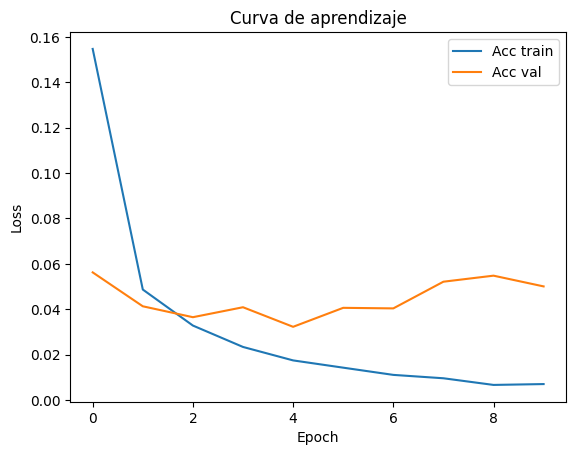

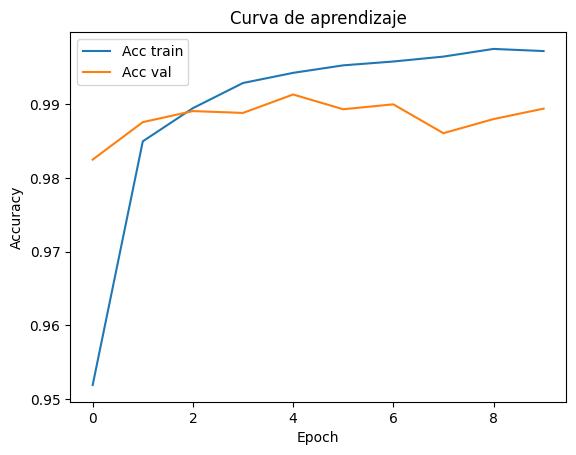

In [24]:
# Visualizamos la función de coste del modelo
plt.plot(history.history['loss'], label='Acc train')
plt.plot(history.history['val_loss'], label='Acc val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curva de aprendizaje')
plt.legend()
plt.show()

# Visualizamos la métrica de accuracy del modelo
plt.plot(history.history['accuracy'], label='Acc train')
plt.plot(history.history['val_accuracy'], label='Acc val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Curva de aprendizaje')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


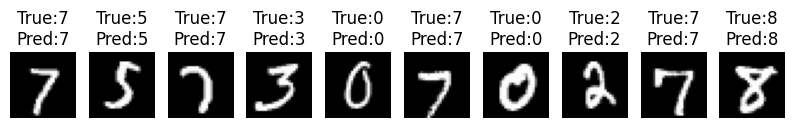

In [68]:
# Visualizamos algunas imágenes del dataset MNIST con sus etiquetas y las predicciones del modelo
num_imagenes = 10
idx = np.random.choice(len(X_test_mnist), num_imagenes)
images = X_test_mnist[idx]
labels = y_test_mnist[idx]
preds = np.argmax(modelo_mnist.predict(images), axis=1)

plt.figure(figsize=(10,2))
for i in range(num_imagenes):
    plt.subplot(1,num_imagenes,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.title(f"True:{labels[i]}\nPred:{preds[i]}")
    plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


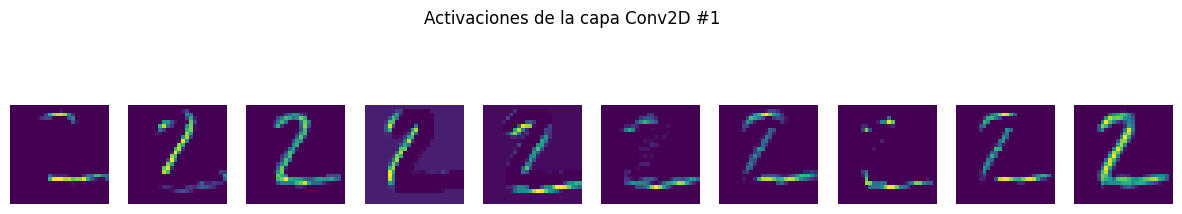

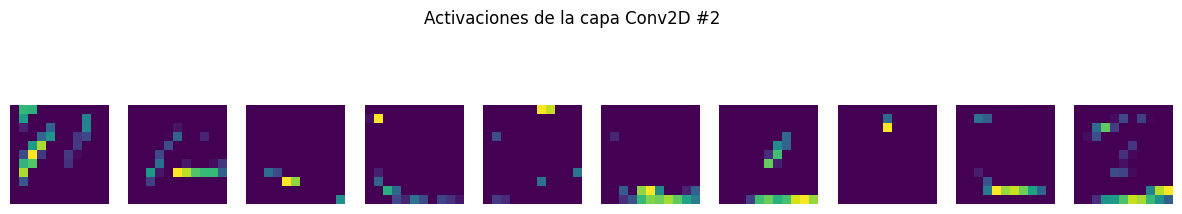

In [26]:
# Elegimos una imagen de test al azar
img = X_test_mnist_preprocessed[1][np.newaxis, ...]

# Ahora que el modelo ha sido llamado, podemos definir el modelo intermedio para extraer activaciones de cada capa
capa_entrada = modelo_mnist.layers[0].input
capa_salida = [layer.output for layer in modelo_mnist.layers if 'conv' in layer.name]
activation_model = models.Model(inputs=capa_entrada, outputs=capa_salida)

activations = activation_model.predict(img)

for i, activation in enumerate(activations):
    num_filters = activation.shape[-1]
    plt.figure(figsize=(15,3))
    for j in range(min(num_filters, 10)):
        plt.subplot(1, 10, j+1)
        plt.imshow(activation[0, :, :, j], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Activaciones de la capa Conv2D #{i+1}')
    plt.show()


### Fashion MNIST

In [61]:
# Definición del modelo CNN para Fashion MNIST
# Utilizaremos una arquitectura sencilla con dos capas convolucionales, seguidas de capas densas
# La primera capa convolucional tendrá 32 filtros de tamaño 3x3, seguida de una capa de max pooling
# La segunda capa convolucional tendrá 64 filtros de tamaño 3x3, seguida de otra capa de max pooling
# Finalmente, aplanamos la salida y añadimos dos capas densas: una con 64 neuronas y activación ReLU
# y una capa de salida con 10 neuronas (una por cada tipo de prenda) y activación softmax


# Compilación del modelo, utilizaremos los mismos parámetros que en los casos de ANN
# Optimizador Adam, función de pérdida sparse_categorical_crossentropy y métrica de accuracy

# Mostramos un resumen del modelo
modelo_fashion.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,690 (483.16 KB)

 Trainable params: 123,690 (483.16 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
%%time
# Entrenar el modelo y guardar el historial para visualizar el aprendizaje


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4883 - loss: 1.3756 - val_accuracy: 0.8095 - val_loss: 0.5022
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7216 - loss: 0.7404 - val_accuracy: 0.8452 - val_loss: 0.4382
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7581 - loss: 0.6551 - val_accuracy: 0.8587 - val_loss: 0.4062
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7840 - loss: 0.5965 - val_accuracy: 0.8740 - val_loss: 0.3806
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7972 - loss: 0.5617 - val_accuracy: 0.8779 - val_loss: 0.3551
CPU times: user 30.9 s, sys: 2.68 s, total: 33.6 s
Wall time: 37 s


In [63]:
# Evaluar el modelo en el conjunto de prueba

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.2%}")

Test Loss: 0.3763, Test Accuracy: 87.32%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


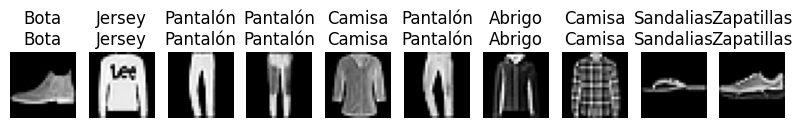

In [64]:
# Visualizamos la función de coste del modelo
idx = np.random.choice(len(X_test_fashion_preprocessed), 10)
idx = range(10)
images = X_test_fashion_preprocessed[idx]
labels = y_test_fashion[idx]
preds = np.argmax(modelo_fashion.predict(images), axis=1)

plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    plt.title(f"{list_class_names_fashion[labels[i]]}\n{list_class_names_fashion[preds[i]]}")
    plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


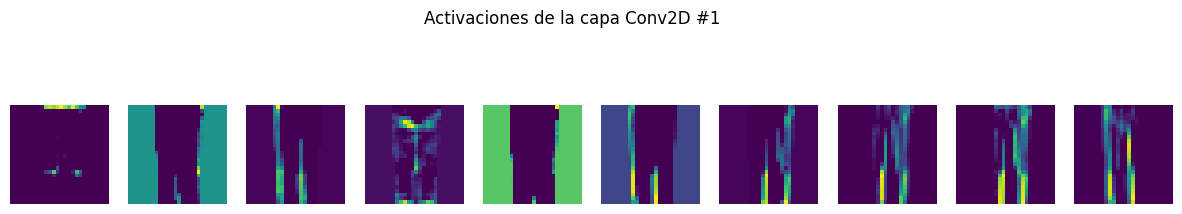

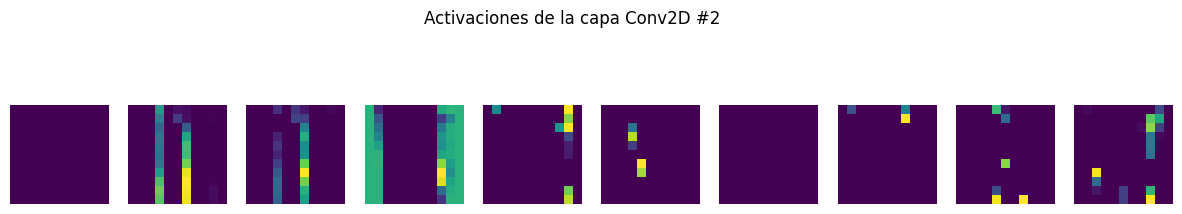

In [65]:
# Elegimos una imagen de test al azar
img = X_test_fashion_preprocessed[3][np.newaxis, ...]

# Ahora que el modelo ha sido llamado, podemos definir el modelo intermedio para extraer activaciones de cada capa
capa_entrada = modelo_fashion.layers[0].input
capa_salida = [layer.output for layer in modelo_fashion.layers if 'conv' in layer.name]
activation_model = models.Model(inputs=capa_entrada, outputs=capa_salida)

activations = activation_model.predict(img)

for i, activation in enumerate(activations):
    num_filters = activation.shape[-1]
    plt.figure(figsize=(15,3))
    for j in range(min(num_filters, 10)):
        plt.subplot(1, 10, j+1)
        plt.imshow(activation[0, :, :, j], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Activaciones de la capa Conv2D #{i+1}')
    plt.show()


## 2. Autoencoders
Un Autoencoder es una red neuronal que está diseñada para comprimir (codificar) los datos de entrada, reducirlos hasta las características más esenciales y, a continuación, reconstruir (decodificar) la entrada original a partir de esa representación comprimida.

<center><img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/0*oJBpyteu7qD0uQ3o.png" alt="Schema Autoencoder" width=500></center>
<center><a src="https://medium.com/@rostepifanov/pre-training-neural-network-for-ecg-processing-via-autoencoders-096cf5a2d552">Fuente: Medium - Pre-training neural networks by autoencoders for ECG processing</a></center>

### 2.1 Reducción de la dimensionalidad
En este caso utilizaremos un dataset de datos tabulares, siendo Iris, para reducir su dimensionalidad y ver cómo funcionaría un autoencoder para este objetivo.

In [32]:
# Cargamos el dataset Iris
X_iris, y_iris = load_iris(return_X_y = True)

In [33]:
# Definimos la dimensión del espacio latente

# También el número de neuronas de la capa de entrada (número de variables X)

#Definimos el autoencoder de una sola capa
# El encoder toma las características de entrada y las transforma en un espacio latente de menor dimensión


# El decoder toma las características del espacio latente y las transforma de nuevo a las características originales


# Creamos el modelo autoencoder combinando el encoder y el decoder


#Compilamos y entramos


# Mostramos un resumen del modelo
modelo_autoencoder.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 4)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Entrenamos el modelo y guardamos el historial para visualizar el aprendizaje
# Utilizamos el mismo conjunto de datos para entrada y salida, ya que el objetivo del autoencoder es reconstruir los datos de entrada
# El número de épocas se puede ajustar según sea necesario

print("Autoencoder MSE: ", modelo_autoencoder.evaluate(X_iris, X_iris, verbose=0))

# Obtenemos el conjunto de datos X codificado en el espacio latente


Autoencoder MSE:  0.05531953647732735
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


#### Entrenamiento un modelo con reducción de la dimensionalidad
Dado que los autoencoders pueden ser usados para reducción de dimensionalidad, a continuación lo que haremos será entrenar un modelo de clasificación sencillo para evaluar su rendimiento al codificar los datos vs no hacerlo.

En este caso lo haremos un con clasificador de KNN, en la parte superior importaremos las librerías correspondientes:
```python
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
```

In [71]:
# Hacemos una división del conjunto de datos en entrenamiento y prueba


# Entrenamos un modelo KNN en el espacio original

print(f"Original accuracy, train: {model_knn.score(X_train, y_train)},test: {model_knn.score(X_test, y_test)}")

# Entrenamos un modelo KNN en el espacio latente
# Hacemos una división del conjunto de datos en entrenamiento usando las variables independientes codificadas y prueba


# Entrenamos un modelo KNN en el espacio latente

print(f"Latent space accuracy, train: {model_knn.score(X_train, y_train)},test: {model_knn.score(X_test, y_test)}")

Original accuracy, train: 0.9732142857142857,test: 0.9736842105263158
Latent space accuracy, train: 0.9285714285714286,test: 0.868421052631579


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


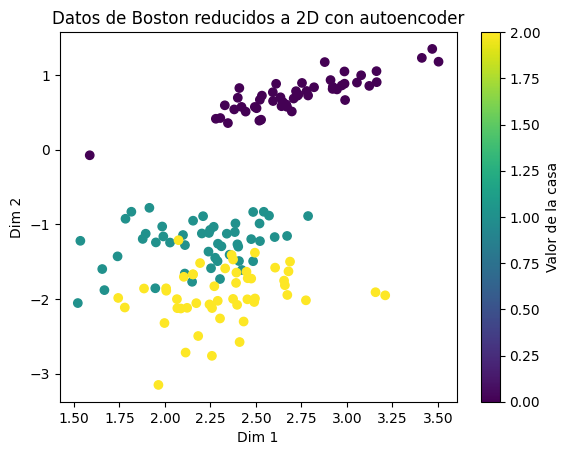

In [36]:
# Usamos el encoder por separado para reducir los datos a 2D
X_iris_2d = encoder.predict(X_iris)

plt.scatter(X_iris_2d[:,0], X_iris_2d[:,1], c=y_iris, cmap='viridis')
plt.colorbar(label='Valor de la casa')
plt.title('Datos de Boston reducidos a 2D con autoencoder')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.show()

### 2.2 Reconstrucción de imágenes

In [37]:
# Definimos la entrada (tamaño de las imágenes) y el espacio latente como una capa densa con 32 neuronas y activación ReLU
size_img = (28, 28, 1)  # Tamaño de las imágenes
dim_espacio_latente = 32  # Dimensión del espacio latente

# Encoder


# Decoder



# Creamos el modelo autoencoder combinando el encoder y el decoder

#Compilamos y entramos

# Mostramos un resumen del modelo
modelo_autoencoder_mnist.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 32)             │        52,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 28, 28, 1)      │        53,072 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,392 (411.69 KB)

 Trainable params: 105,392 (411.69 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Entrenamos el modelo y guardamos el historial para visualizar el aprendizaje
# Utilizamos el mismo conjunto de datos para entrada y salida, ya que el objetivo del autoencoder es reconstruir los datos de entrada
# El número de épocas se puede ajustar según sea necesario


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0469
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0128
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0120
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0116
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0111
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0109
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0108


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


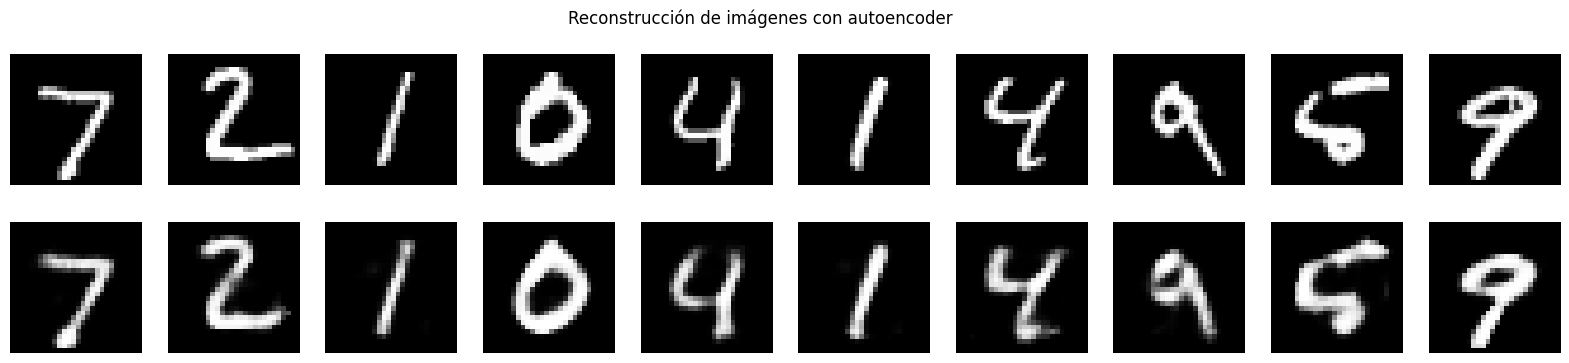

In [39]:
# Obtenemos la predicción de las imágenes originales reconstruidas tomando 10 por ejemplo

# Visualizamos las imágenes originales y las reconstruidas
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    plt.subplot(2, 10, i+1)
    plt.imshow(X_test_mnist_preprocessed[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Original', size=15)

    # Reconstruida
    plt.subplot(2, 10, 10+i+1)
    plt.imshow(decoded_imgs[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Reconstruida', size=15)
plt.suptitle("Reconstrucción de imágenes con autoencoder")
plt.show()


El siguiente ejemplo muestra cómo unas imágenes ruidosas pueden ser limpiadas por un autoencoder de denoising.
+ Para ello usamos el mismo encoder y decoder que antes, pero ahora entrenamos con imágenes ruidosas como entrada y las imágenes originales como salida.
+ Esto permite que el autoencoder aprenda a eliminar el ruido de las imágenes.

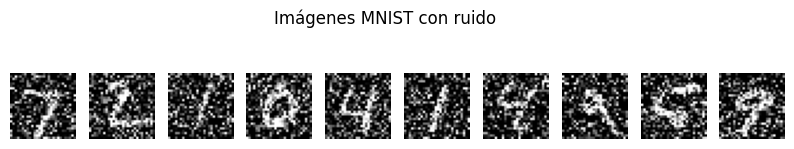

In [40]:
# Usamos el mismo x_train, x_test de antes (MNIST normalizado [0,1])
noise_factor = 0.5
X_train_mnist_noisy = X_train_mnist_preprocessed + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_mnist_preprocessed.shape)
X_test_mnist_noisy = X_test_mnist_preprocessed + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test_mnist_preprocessed.shape)

# Limitar a [0, 1]
X_train_mnist_noisy = np.clip(X_train_mnist_noisy, 0., 1.)
X_test_mnist_noisy = np.clip(X_test_mnist_noisy, 0., 1.)

# Visualizar ejemplos
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_test_mnist_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.suptitle("Imágenes MNIST con ruido")
plt.show()


In [41]:
# Definimos el autoencoder para denoising
# Usamos el modelo autoencoder_mnist definido anteriormente, pero lo clonamos para no modificar el original
modelo_autoencoder_denoise = tf.keras.models.clone_model(modelo_autoencoder_mnist)
modelo_autoencoder_denoise.compile(optimizer='adam', loss='mse')

# Entrenamos el autoencoder para denoising
# Usamos las imágenes ruidosas como entrada y las imágenes originales como salida
history = modelo_autoencoder_denoise.fit(
    X_train_mnist_noisy, X_train_mnist_preprocessed,  # ¡Entrada ruidosa, salida limpia!
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test_mnist_noisy, X_test_mnist_preprocessed)
)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0840 - val_loss: 0.0396
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0379 - val_loss: 0.0332
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0329 - val_loss: 0.0305
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0303 - val_loss: 0.0285
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0285 - val_loss: 0.0269
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0271 - val_loss: 0.0261
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0262 - val_loss: 0.0253
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0253 - val_loss: 0.0245
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0247 - val_loss: 0.0240
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0241 - val_loss: 0.0235


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


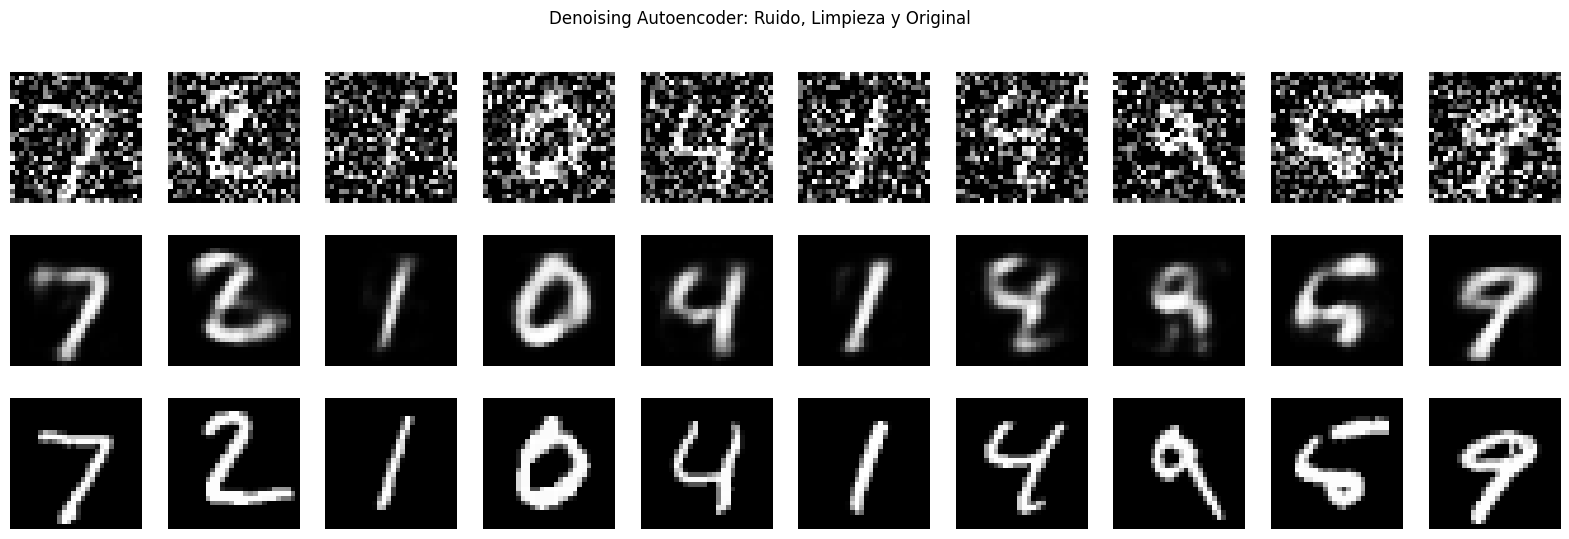

In [42]:
# Obtenemos la predicción del modelo autoencoder de denoising
# Usamos las imágenes de test ruidosas para obtener las reconstrucciones limpias
# Esto nos dará las imágenes reconstruidas a partir de las imágenes ruidosas
decoded_imgs = modelo_autoencoder_denoise.predict(X_test_mnist_noisy[:10])

plt.figure(figsize=(20, 6))
for i in range(10):

    # Imagen ruidosa
    plt.subplot(3, 10, i+1)
    plt.imshow(X_test_mnist_noisy[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Noisy', size=12)

    # Reconstrucción (limpia)
    plt.subplot(3, 10, 10+i+1)
    plt.imshow(decoded_imgs[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Denoised', size=12)

    # Imagen original
    plt.subplot(3, 10, 20+i+1)
    plt.imshow(X_test_mnist_preprocessed[i].reshape(28,28), cmap='gray')
    plt.axis('off')
    if i == 0: plt.ylabel('Original', size=12)

plt.suptitle("Denoising Autoencoder: Ruido, Limpieza y Original")
plt.show()


## 3. Embeddings
Cuando procesamos texto, necesitamos transformar las palabras en números para que los modelos puedan entender (como ya hemos visto en algunos ejemplos). Algunos de los métodos  más típicos que permiten transformar texto en valores numéricos pueden ser: One-hot encoding, Bag-of-Words, TF-IDF o Word2Vec.

| Técnica  | Forma del vector             | ¿Disperso o denso? | ¿Captura significado? |
| -------- | ---------------------------- | ------------------ | --------------------- |
| One-hot  | Muy largo, ceros y unos      | Disperso           | No                    |
| BoW      | Muy largo, ceros y cuentas   | Disperso           | No                    |
| TF-IDF   | Muy largo, valores decimales | Disperso           | Parcialmente          |
| Word2Vec | Más corto, valores decimales | Denso              | Sí                    |

In [ ]:
# Tokenización simple convirtiendo los tweets a minúsculas y los separamos en palabras


### One-hot Encoding
Cada frase se convierte en una matriz donde cada columna es una palabra distinta y cada fila representa si la palabra aparece (1) o no (0). Para ello utilizaremos `MultiLabelBinarizer` ya que nos permite realizar esta técnica. A diferencia de `OneHotEncoder`, es que ésta no permite tener varias palabras (al estar pensada para variables categóricas). Para importar la clase que utilizaremos:

```python
from sklearn.preprocessing import MultiLabelBinarizer
```

In [43]:
# One-hot encoding usando MultiLabelBinarizer


# Visualizamos el resultado del one-hot encoding
df_one_hot = pd.DataFrame(emb_one_hot, columns=mlb.classes_)

print("One-hot encoding:")
df_one_hot.head()

One-hot encoding:


,a,aa,aaaand,aaadvantage,aaalwayslate,aaba,aacom,aadavantage,aadelay,aadfw,...,zip,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich,zurichnew
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Bag-of-Words (BoW)
Cada frase se convierte en un vector con el número de veces que aparece cada palabra. Para ello utilizamos la clase `CountVectorizer`, la importamos de la siguiente forma:

```python
from sklearn.feature_extraction.text import CountVectorizer
```

In [44]:
# Bag-of-Words (BoW) usando CountVectorizer


# Visualizamos el resultado del Bag-of-Words
df_bow = pd.DataFrame(emb_bow.toarray(), columns=vectorizer_bow.get_feature_names_out())

print("Bag-of-Words:")
df_bow.head()

Bag-of-Words:


,aa,aaaand,aaadvantage,aaalwayslate,aaba,aacom,aadavantage,aadelay,aadfw,aadv,...,zip,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich,zurichnew
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF (Term Frequency-Inverse Document Frequency)
El TF-IDF es una técnica que pondera la importancia de una palabra en un documento en relación con su frecuencia en el corpus completo, en el caso previo BoW no tendría en cuenta esa relevancia dentro de dicho corpus. Utilizamos `TfidfVectorizer` y la importamos:

```python
from sklearn.feature_extraction.text import TfidfVectorizer
```

In [45]:
# TF-IDF usando TfidfVectorizer


# Visualizamos el resultado del TF-IDF
df_tfidf = pd.DataFrame(emb_tfidf.toarray(), columns=vectorizer_tfidf.get_feature_names_out()).round(2)
print("TF-IDF:")
df_tfidf.head()

TF-IDF:


,aa,aaaand,aaadvantage,aaalwayslate,aaba,aacom,aadavantage,aadelay,aadfw,aadv,...,zip,zippers,zombie,zone,zones,zoom,zrh,zukes,zurich,zurichnew
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word2Vec
Cada palabra es un vector denso para representar una frase, hacemos la media de los vectores de sus palabras. En este caso se utilizará la librería `Gensim` para crear el modelo Word2Vec. Primero, instalamos la librería si no está instalada:
```bash
uv pip install gensim
```

Posteriormente importaremos el modelo de Word2Vec:
```python
from gensim.models import Word2Vec
```

Principales hiperparámetros:
+ `vector_size=10`: Dimensionalidad de los vectores (10 características por palabra)
+ `min_count=1`: Incluye todas las palabras, incluso las que aparecen solo una vez
+ `workers=1`: Número de hilos para el entrenamiento (paralelización)
+ `sg=1`: Utiliza el algoritmo Skip-gram (en vez de CBOW), que suele ser mejor para palabras poco frecuentes

[['what', 'said'],
 ['plus', 'youve', 'added', 'commercials', 'to', 'the', 'experience', 'tacky'],
 ['i',
  'didnt',
  'today',
  'must',
  'mean',
  'i',
  'need',
  'to',
  'take',
  'another',
  'trip'],
 ['its',
  'really',
  'aggressive',
  'to',
  'blast',
  'obnoxious',
  'entertainment',
  'in',
  'your',
  'guests',
  'faces',
  'amp',
  'they',
  'have',
  'little',
  'recourse'],
 ['and', 'its', 'a', 'really', 'big', 'bad', 'thing', 'about', 'it'],
 ['seriously',
  'would',
  'pay',
  'a',
  'flight',
  'for',
  'seats',
  'that',
  'didnt',
  'have',
  'this',
  'playing',
  'its',
  'really',
  'the',
  'only',
  'bad',
  'thing',
  'about',
  'flying',
  'va'],
 ['yes',
  'nearly',
  'every',
  'time',
  'i',
  'fly',
  'vx',
  'this',
  'ear',
  'worm',
  'wont',
  'go',
  'away'],
 ['really',
  'missed',
  'a',
  'prime',
  'opportunity',
  'for',
  'men',
  'without',
  'hats',
  'parody',
  'there'],
 ['well', 'i', 'didntbut', 'now', 'i', 'do', 'd'],
 ['it',
  'was',


In [47]:
# Entrenamos el modelo


In [48]:
# Obtenemos el embedding de la primera frase del corpus


# Mostramos qué hace np.vstack


Primer tweet 'what said': [ 0.68520206 -0.26900375  0.56898284  0.41372222 -0.33825362 -0.3532599
  1.6752083   0.33389884 -1.2550948  -0.791664  ]
Aplicamos np.vstack para obtener un array 2D con los embeddings de todas las frases del corpus:


array([[ 0.68520206],
       [-0.26900375],
       [ 0.56898284],
       [ 0.41372222],
       [-0.33825362],
       [-0.3532599 ],
       [ 1.6752083 ],
       [ 0.33389884],
       [-1.2550948 ],
       [-0.791664  ]], dtype=float32)

In [49]:
# Obtenemos los embeddings de las frases en el corpus de tweets
# Usamos una comprensión de lista para aplicar la función a cada frase del corpus


In [51]:
# Solo mostramos las 5 primeras dimensiones para que sea legible
print("Word2Vec embeddings (primeras 5 dimensiones):")


Word2Vec embeddings (primeras 5 dimensiones):
[[ 0.69 -0.27  0.57  0.41 -0.34]
 [ 0.37 -0.22  0.39  0.25  0.34]
 [ 0.6  -0.01  0.68  0.42  0.01]
 ...
 [ 0.48 -0.47  0.29  0.23 -0.04]
 [ 0.59 -0.14  0.46  0.4   0.01]
 [ 0.39 -0.11  0.7   0.18  0.05]]


In [52]:
# Visualizamos el embedding de la palabra "love"
word = "love"
if word in modelo_w2v.wv:
    embedding = modelo_w2v.wv[word]
    print(f"Embedding de la palabra '{word}': {embedding}")
else:
    print(f"La palabra '{word}' no está en el vocabulario del modelo Word2Vec.")

Embedding de la palabra 'love': [ 0.75888795 -0.52276164  0.30925852  0.68549466 -0.4758164   0.10440046
  1.6386791   1.3683715  -0.42764592  0.09838876]


### Comparación entre diferentes métodos

In [53]:
indice_tweet = 1
print("\nFrase original:")
print(tweets_corpus[indice_tweet])
print("\t- One-hot:", emb_one_hot[indice_tweet])
print("\t- BoW:", emb_bow.toarray()[indice_tweet])
print("\t- TF-IDF:", emb_tfidf.toarray()[indice_tweet].round(2))
print("\t- Word2Vec:", emb_w2v[indice_tweet][:5])  # Primeras 5 dimensiones


Frase original:
plus youve added commercials to the experience tacky
	- One-hot: [0 0 0 ... 0 0 0]
	- BoW: [0 0 0 ... 0 0 0]
	- TF-IDF: [0. 0. 0. ... 0. 0. 0.]
	- Word2Vec: [ 0.37108907 -0.22384833  0.39446408  0.24867344  0.3359028 ]


### Visualización de embeddings
Se pueden utilizar modelos de reducción de la dimensionalidad para visualizar los embeddings. En este caso utilizaremos t-SNE.

In [54]:
# Palabras más frecuentes, obtenemos las palabras y sus vectores


In [55]:
# Reduce a 2D con t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
coords = tsne.fit_transform(vectors)

In [56]:
# Visualización con Plotly
fig = px.scatter(
    x=coords[:,0], y=coords[:,1],
    text=words,
    labels={'x': 't-SNE dim 1', 'y': 't-SNE dim 2'},
    title="Palabras más frecuentes en el espacio Word2Vec (t-SNE)"
)
fig.update_traces(textposition='top center')
fig.update_layout(width=800, height=600, showlegend=False)
fig.show()

In [57]:
# Visualización de los tweets en el espacio Word2Vec usando t-SNE
numero_tweets = 20 # Número de tweets a visualizar

# Reducimos a 2D con t-SNE
tsne_frases = TSNE(n_components=2, random_state=42, perplexity=5)
coords_frases = tsne_frases.fit_transform(emb_w2v[:numero_tweets,])

# Visualización con Plotly
fig = px.scatter(
    x=coords_frases[:,0], y=coords_frases[:,1],
    text=[f"Tweet {i}: {frase[:30]}..." for i, frase in enumerate(tweets_corpus[:numero_tweets], 1)],
    labels={'x': 't-SNE dim 1', 'y': 't-SNE dim 2'},
    title="Tweets en el espacio Word2Vec (t-SNE)"
)
fig.update_traces(textposition='top center')
fig.update_layout(width=900, height=700, showlegend=False)
fig.show()

## 99. Ejercicios


### 1. Redes Neuronales Convolucionales

#### 1.1 Diferentes arquitecturas
Utiliza Digits y Fashion para modificar el número de filtros (por ejemplo, cambia 32 y 64 por 16 y 128), añade o elimina las capas convolucionales, o cambia el tamaño del kernel de (3,3) a (5,5) para poder ver cómo cambia el accuracy en el conjunto de test.

```python
modelo_mnist = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Forma de las imágenes MNIST (28x28 píxeles, 1 canal)
    layers.Conv2D(32, 3, activation='relu'),  # Primera capa convolucional
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 clases
])
```

#### 1.2 Evalúa el modelo
Viendo ambos datasets, cuáles dirías que son los números o prendas que mejor y peor han aprendido los modelos.

### 2. Autoencoders

#### 2.1 Varía el espacio latente
Hemos trabajado con un espacio latente de dos neuronas, prueba a variar esta capa en cuanto al número de neuronas. Hazlo también con las otras capas.

### 3. Embeddings

#### 3.1 Utiliza otro corpus para Word2Vec
Tomando el siguiente corpus visualiza cómo se visualizarían las diferentes palabras y frases utilizando la representación de embedddings de Word2Vec
```python
corpus = [
    "El médico y la médica ayudan a los pacientes",
    "La ingeniera y el ingeniero construyen un puente",
    "El profesor y la profesora enseñan matemáticas",
    "El artista y la artista pintan cuadros hermosos",
    "La persona lee un libro en el parque",
    "La estudiante y el estudiante estudian para el examen",
    "La hermana y el hermano juegan en el jardín",
    "El león y la leona cuidan a sus crías",
    "La amiga y el amigo viajan por el mundo",
    "El perro y la perra corren en el campo",
    "El gato y la gata duermen en la casa",
    "La doctora y el doctor investigan nuevas medicinas",
    "El piloto y la piloto vuelan aviones grandes",
    "El músico y la música tocan instrumentos en la orquesta",
    "La jefa y el jefe coordinan el equipo de trabajo",
    "La niña y el niño dibujan juntos",
    "El abuelo y la abuela cuentan historias interesantes",
    "El tigre y la tigresa cazan juntos en la selva",
    "La científica y el científico descubren nuevas especies",
    "El cocinero y la cocinera preparan recetas deliciosas",
    "El sol y la luna brillan en el cielo",
    "El río y el lago tienen agua limpia",
    "La montaña y el valle están llenos de árboles",
    "La persona amiga escucha y apoya siempre",
    "El grupo de personas comparte ideas en la reunión"
]
```